In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline
def show(img):   
    cv2.imshow('img',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('dark_background')


In [19]:
# df, img 불러오고 model화 시키기 전 전처리과정
img_size = 251
model_weight = "tjnet_kaggle.h5"

df_path = ".."
img_path = "../boneage-training-dataset/boneage-training-dataset"


df = pd.read_csv(df_path+"/boneage-training-dataset.csv")
l = len(df)

file_name = np.array([f"{df.id[i]}.png" for i in range(l)])

# df['boneage'] = df.BA*12
ba_mean = df.boneage.mean()
ba_std = df.boneage.std()
df["BA_z"] = (df.boneage-ba_mean)/ba_std
df["filename"] = file_name
df["gender"] = df["male"]*1

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size = 0.2, random_state = 0)

In [16]:
img_path+"/"+file_name[0]

'../boneage-training-dataset/boneage-training-dataset/1377.jpg'

In [15]:
cv2.imread()

In [8]:
def multi_generator(df):
    gender_in = np.array(df.gender)
    img_in = []
    age = np.array(df.BA_z)
    
    for file_path in df.filename:
        img = cv2.imread(img_path+'/'+file_path)
        small = cv2.resize(img, (img_size,img_size),cv2.INTER_AREA)
        img_in.append(small)
        
    img_in = np.array(img_in)
        
    
    return [gender_in,img_in],age

In [9]:
# process시각화 및 손실함수

def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

from tensorflow.keras.metrics import mean_absolute_error

def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((ba_std*x_p + ba_mean), (ba_std*y_p + ba_mean)) 

In [10]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


In [11]:
i_input = Input(shape = (img_size,img_size,3))
#block 1
conv1 = Conv2D(32,3,activation = 'relu')(i_input)
conv2 = Conv2D(32,3,activation = 'relu')(conv1)
conv3 = Conv2D(64,3,activation = 'relu',padding='same')(conv2)
pool1 = MaxPool2D(pool_size=(2,2))(conv3)
#block 2
conv4 = Conv2D(60,1,activation = 'relu')(pool1)
conv5 = Conv2D(192,3,activation = 'relu')(conv4)
pool2 = MaxPool2D(pool_size=(2,2))(conv5)
#block 3
conv6 = Conv2D(512,3,activation = 'relu')(pool2)
pool3 = MaxPool2D(pool_size=(2,2))(conv6)
#block 4
conv7 = Conv2D(1024,3,activation = 'relu',padding='same')(pool3)
pool4 = MaxPool2D(pool_size=(2,2))(conv7)
#block 5
conv8 = Conv2D(2048,3,activation = 'relu')(pool4)
conv9 = Conv2D(2048,5,activation = 'relu')(conv8)
pool5 = AveragePooling2D(pool_size=(8,8))(conv9)
#flat
i_output = Flatten()( pool5)
# i_output = Dense(1024)(flat)

i_model = Model(inputs = i_input, outputs = i_output)


In [12]:
g_input = Input(shape = (1,))
g_output = Dense(64,activation = 'relu')(g_input)

g_model = Model(inputs = g_input,outputs = g_output)




con = concatenate([g_model.output, i_model.output])
dense1 = Dense(1024,activation='relu')(con)
# batch = BatchNormalization()(dense1)
# drop = Dropout(0.5)(dense1)
dense2 = Dense(512,activation='relu')(dense1)
# dense3 = Dense(10,activation='softmax')(dense2)
model_out = Dense(1,activation = "linear")(dense2)

model = Model([g_input,i_input],model_out)
model.compile(loss ='mse', optimizer= 'adam', metrics = [mae_in_months] )

In [13]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 251, 251, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 249, 249, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 247, 247, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 247, 247, 64) 18496       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [14]:
train_X,train_y = multi_generator(train_df)
val_X, val_y = multi_generator(val_df)

In [17]:

for i in range(len(df)):
    small = cv2.resize(imgs[i],(512,512),interpolation=cv2.INTER_AREA)
    cv2.imwrite("../small_kaggle/{df.id[i]}.jpg",small)

Epoch 1/20
316/316 [==============================] - 89s 281ms/step - loss: 0.0884 - mae_in_months: 9.4854 - val_loss: 0.1710 - val_mae_in_months: 12.5540
Epoch 2/20
316/316 [==============================] - 91s 289ms/step - loss: 0.0799 - mae_in_months: 9.0411 - val_loss: 0.1456 - val_mae_in_months: 11.6636
Epoch 3/20
316/316 [==============================] - 92s 291ms/step - loss: 0.0677 - mae_in_months: 8.3882 - val_loss: 0.1444 - val_mae_in_months: 11.3301
Epoch 4/20
316/316 [==============================] - 85s 268ms/step - loss: 0.0628 - mae_in_months: 8.0321 - val_loss: 0.1571 - val_mae_in_months: 12.1802
Epoch 5/20
316/316 [==============================] - 85s 268ms/step - loss: 0.0585 - mae_in_months: 7.7982 - val_loss: 0.1462 - val_mae_in_months: 11.4194
Epoch 6/20
316/316 [==============================] - 85s 268ms/step - loss: 0.0546 - mae_in_months: 7.5651 - val_loss: 0.1579 - val_mae_in_months: 11.9606
Epoch 7/20
316/316 [==============================] - 85s 268ms/

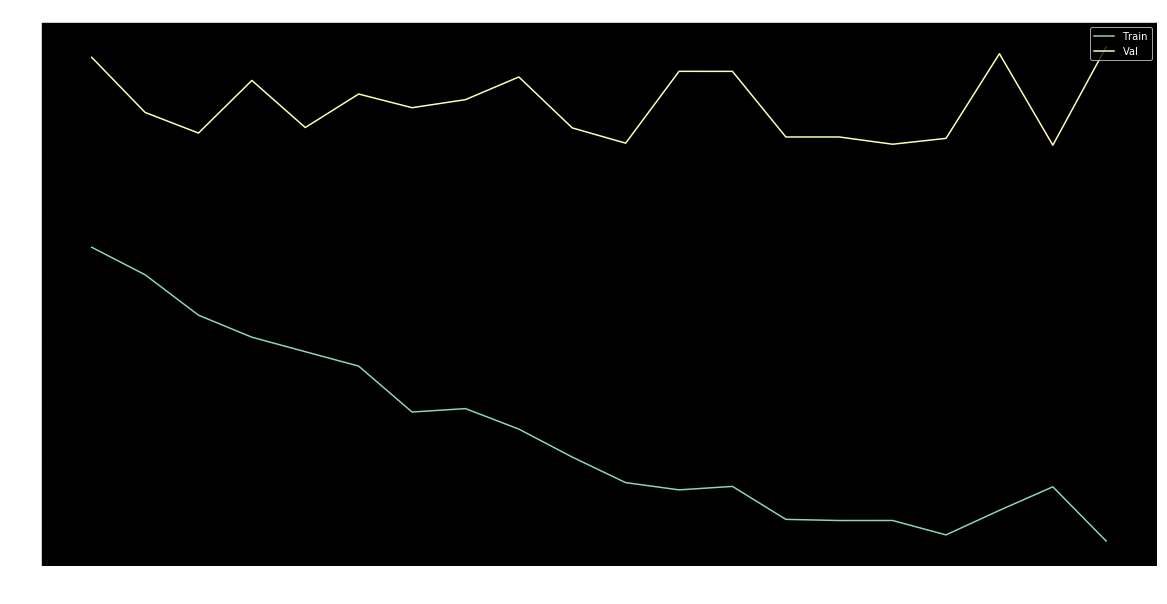

In [20]:
# 모델 fit

epochs = 20
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 10,
                              verbose=0, mode='auto')

mc = ModelCheckpoint(model_weight, monitor='val_loss', mode='min', save_best_only=True)


callbacks = [early_stopping,mc]


#fit model
history = model.fit(train_X,train_y,
                    validation_data = (val_X,val_y),
                    epochs = epochs,
                    callbacks= callbacks)
plot_it(history)

In [21]:
model.load_weights(model_weight)

In [22]:
pred = model.predict(val_X)*ba_std+ba_mean
mse, mae = model.evaluate(val_X,val_y)

from sklearn.metrics import r2_score
r2 = r2_score(val_df.boneage,pred)
print(f"mae_year : {mae/12}, mse : {mse/12},r2_score : {r2}" )

79/79 [==============================] - 7s 82ms/step - loss: 0.1352 - mae_in_months: 11.1497
mae_year : 0.9291458129882812, mse : 0.01126478984951973,r2_score : 0.8700702230499666


In [23]:
from sklearn.metrics import mean_absolute_error
v = val_y*ba_std+ba_mean
mean_absolute_error(np.round(pred),v)/12,mean_absolute_error(pred,v)/12

(0.928260007927071, 0.9291458434796519)

In [24]:
result_df = pd.read_csv("result.csv")
result_df.loc[len(result_df)]=(model_weight,mae/12,mse/12,r2,True,False)
result_df.to_csv("result.csv",index=False)
result_df

,model,mae,mse,r2_score,roi,class
0,xception++,1.540548,17.096090,-180.695600,False,False
1,vgg-ba,1.160614,0.073136,-0.303073,False,False
2,vgg-ba,0.670392,0.025254,-0.570250,True,False
3,xception++,0.557815,0.016407,-0.361841,True,False
4,pre xception++,0.639215,0.022091,-1.055396,True,False
5,xception+gender,0.551765,0.017635,0.766628,True,False
6,pre-xception+gender,0.600951,0.020432,0.729614,True,False
7,tjnet-gender2,0.407535,0.009509,0.874158,True,False
8,tjnet_kaggle.h5,0.929146,0.011265,0.870070,True,False
